In [1]:
import os
import umap
import torch
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm
from SpatialGlue.utils import clustering
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors


warnings.filterwarnings("ignore")
# 环境设置
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

def jump_up_one_dir():
    new_dir = Path().resolve().parent
    os.chdir(new_dir)
    print("✅ 当前工作目录跳转至:", new_dir)

jump_up_one_dir()



✅ 当前工作目录跳转至: C:\Users\Jeming\Desktop\T0


### 环境设置：  os.environ['R_HOME'] = "C:/SG/APP/R"  # 需要下载一个 R 语言的‘mclust’算法的路径

In [ ]:
# 环境设置
# 如果完成了R的本体全局变量配置，这一栏不需要。如果没有配置，或者出现路径问题，请在此处配置R的环境
os.environ['R_HOME'] = "C:\Program Files\R\R-4.5.0"  # R 语言的‘mclust’算法的路径，可通过指定R_HOME环境变量来设置
print("✅ R_HOME:", os.environ['R_HOME'])


✅ R_HOME: C:\Program Files\R\R-4.5.0


R[write to console]: 将程序包安装入'C:/Users/Jeming/AppData/Local/R/win-library/4.5'
(因为'lib'没有被指定)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.5/mclust_6.1.1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4138837 bytes (3.9 MB)

R[write to console]: downloaded 3.9 MB




程序包'mclust'打开成功，MD5和检查也通过

下载的二进制程序包在
	C:\Users\Jeming\AppData\Local\Temp\Rtmpy0UAog\downloaded_packages里


In [ ]:
# 如果没有在R GUI中安装mclust，通过运行如下代码安装
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects

# 导入 R 的 utils 包
utils = rpackages.importr('utils')

# 选择一个 CRAN 镜像（如果没有设置会报错）
utils.chooseCRANmirror(ind=1)  # 或者你可以设置为清华镜像见下

# 安装 mclust 包
robjects.r('install.packages("mclust")')

In [3]:
# 加载数据/home/musg/code_file/2025/T1-data
# 导入数据
file_fold = './0-dataset/'  
adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
print("✅ h5ad读取数据完成！")


✅ h5ad读取数据完成！


In [4]:
T1_size1 = pd.read_csv('./5-step/1-emb.csv', index_col=0)
T1_size2 = pd.read_csv('./5-step/2-emb.csv', index_col=0)
T1_size3 = pd.read_csv('./5-step/3-emb.csv', index_col=0)
T1_size4 = pd.read_csv('./5-step/4-emb.csv', index_col=0)
T1_size5 = pd.read_csv('./5-step/5-emb.csv', index_col=0)
print("✅ csv读取数据完成！")

✅ csv读取数据完成！


In [5]:
adata = adata_omics1.copy()
adata.obsm['size1_emb'] = T1_size1.values
adata.obsm['size2_emb'] = T1_size2.values
adata.obsm['size3_emb'] = T1_size3.values
adata.obsm['size4_emb'] = T1_size4.values
adata.obsm['size5_emb'] = T1_size5.values

# 清洗 adata.obs 所有字符串列，确保无乱码
for col in adata.obs.columns:
    if adata.obs[col].dtype == object:
        adata.obs[col] = adata.obs[col].astype(str).apply(
            lambda x: x.encode('utf-8', errors='ignore').decode('utf-8', errors='ignore')
        )


print("✅ adata数据整合完成！")

✅ adata数据整合完成！


### 需要的话可以下一个 SpatialGlue的包   pip install spatialglue

### 图1：umap修改

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


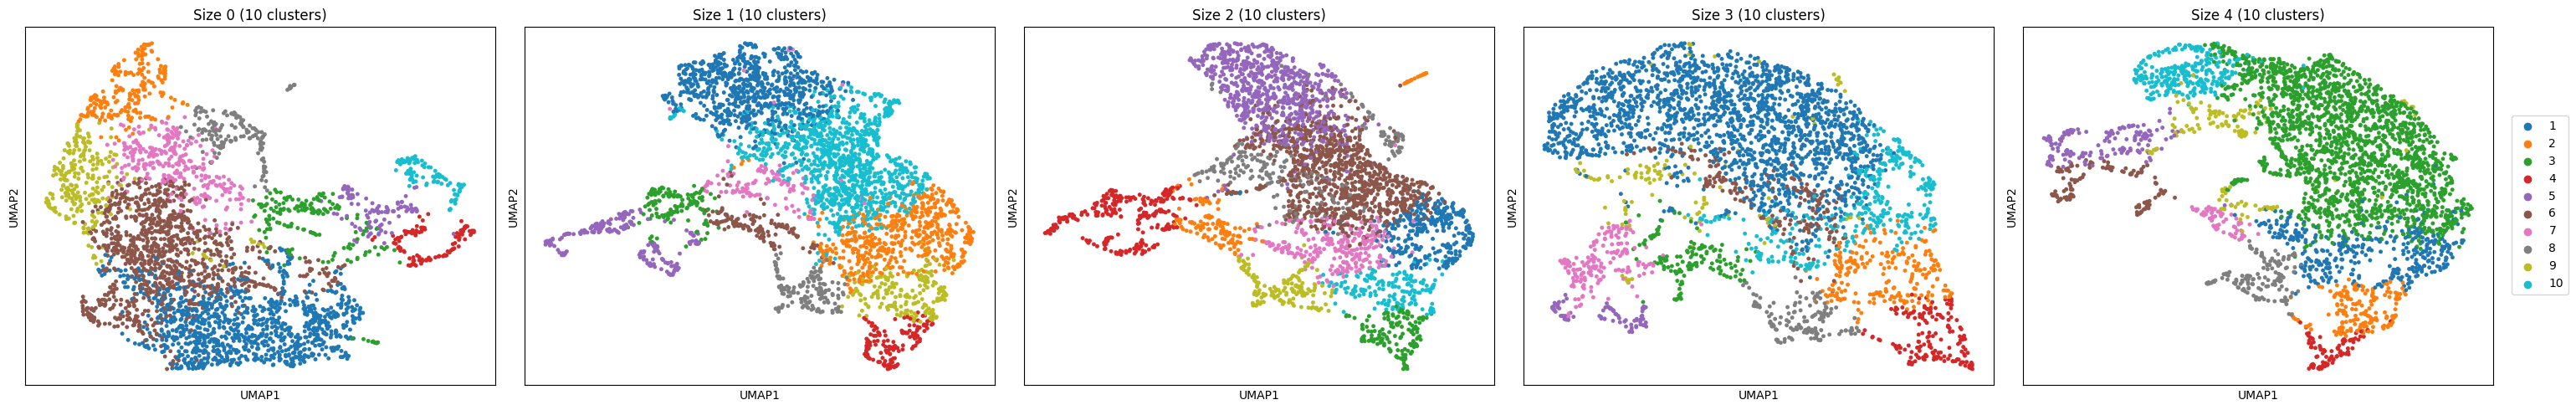

In [ ]:
### 图1 UAMP 可视化
import matplotlib.pyplot as plt
from SpatialGlue.utils import clustering
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import scanpy as sc

# R

tool = 'mclust'
fig, ax_list = plt.subplots(1, 5, figsize=(30, 5))  # 增大图像宽度，确保子图更紧凑

# 展示真实标签图
#sc.pl.embedding(adata, basis='spatial', color='final_annot', title='Ground Truth (Spatial)', ax=ax_list[0], s=50, show=False)

# 对每个嵌入进行 Mclust 聚类并可视化



for i in range(5):
    emb_key = f'size{i+1}_emb'
    cluster_key = f'size{i+1}_mclust_10'  # 假设聚类的结果是 10 类
    # 聚类
    clustering(adata, key=emb_key, add_key=cluster_key, n_clusters=10, method=tool, use_pca=True)
    # UMAP 可视化
    sc.pp.neighbors(adata, use_rep=emb_key, n_neighbors=10)
    sc.tl.umap(adata)
    # 在对应的子图上绘制聚类结果
    sc.pl.umap(adata, color=cluster_key, ax=ax_list[i], title=f'Size {i} (10 clusters)', s=50, show=False)

    # 删除当前子图的图例（不在子图中显示）
    ax_list[i].get_legend().set_visible(False)

# 合并图例并将其显示在最后一个子图的右侧
handles, labels = ax_list[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.tight_layout()

plt.show()

In [ ]:
# ### 图2 空间聚类可视化结果

# tool = 'mclust'
# fig, ax_list = plt.subplots(1, 5, figsize=(30, 5))  # 增大图像宽度，确保子图更紧凑

# # 展示真实标签图
# #sc.pl.embedding(adata, basis='spatial', color='final_annot', title='Ground Truth (Spatial)', ax=ax_list[0], s=50, show=False)

# # 对每个嵌入进行 Mclust 聚类并可视化
# for i in range(5):
#     emb_key = f'size{i+1}_emb'
#     cluster_key = f'size{i+1}_mclust_10'  # 假设聚类的结果是 10 类
#     # 空间嵌入可视化
#     sc.pl.embedding(adata, basis='spatial', color=cluster_key, ax=ax_list[i], title=f'Spatial Mclust {i+1} (10 clusters)', s=50, show=False)
    
#     # 删除当前子图的图例（不在子图中显示）
#     ax_list[i].get_legend().set_visible(False)

# # 合并图例并将其显示在最后一个子图的右侧
# handles, labels = ax_list[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

# plt.tight_layout()  

# plt.show()


### 图2：domain修改

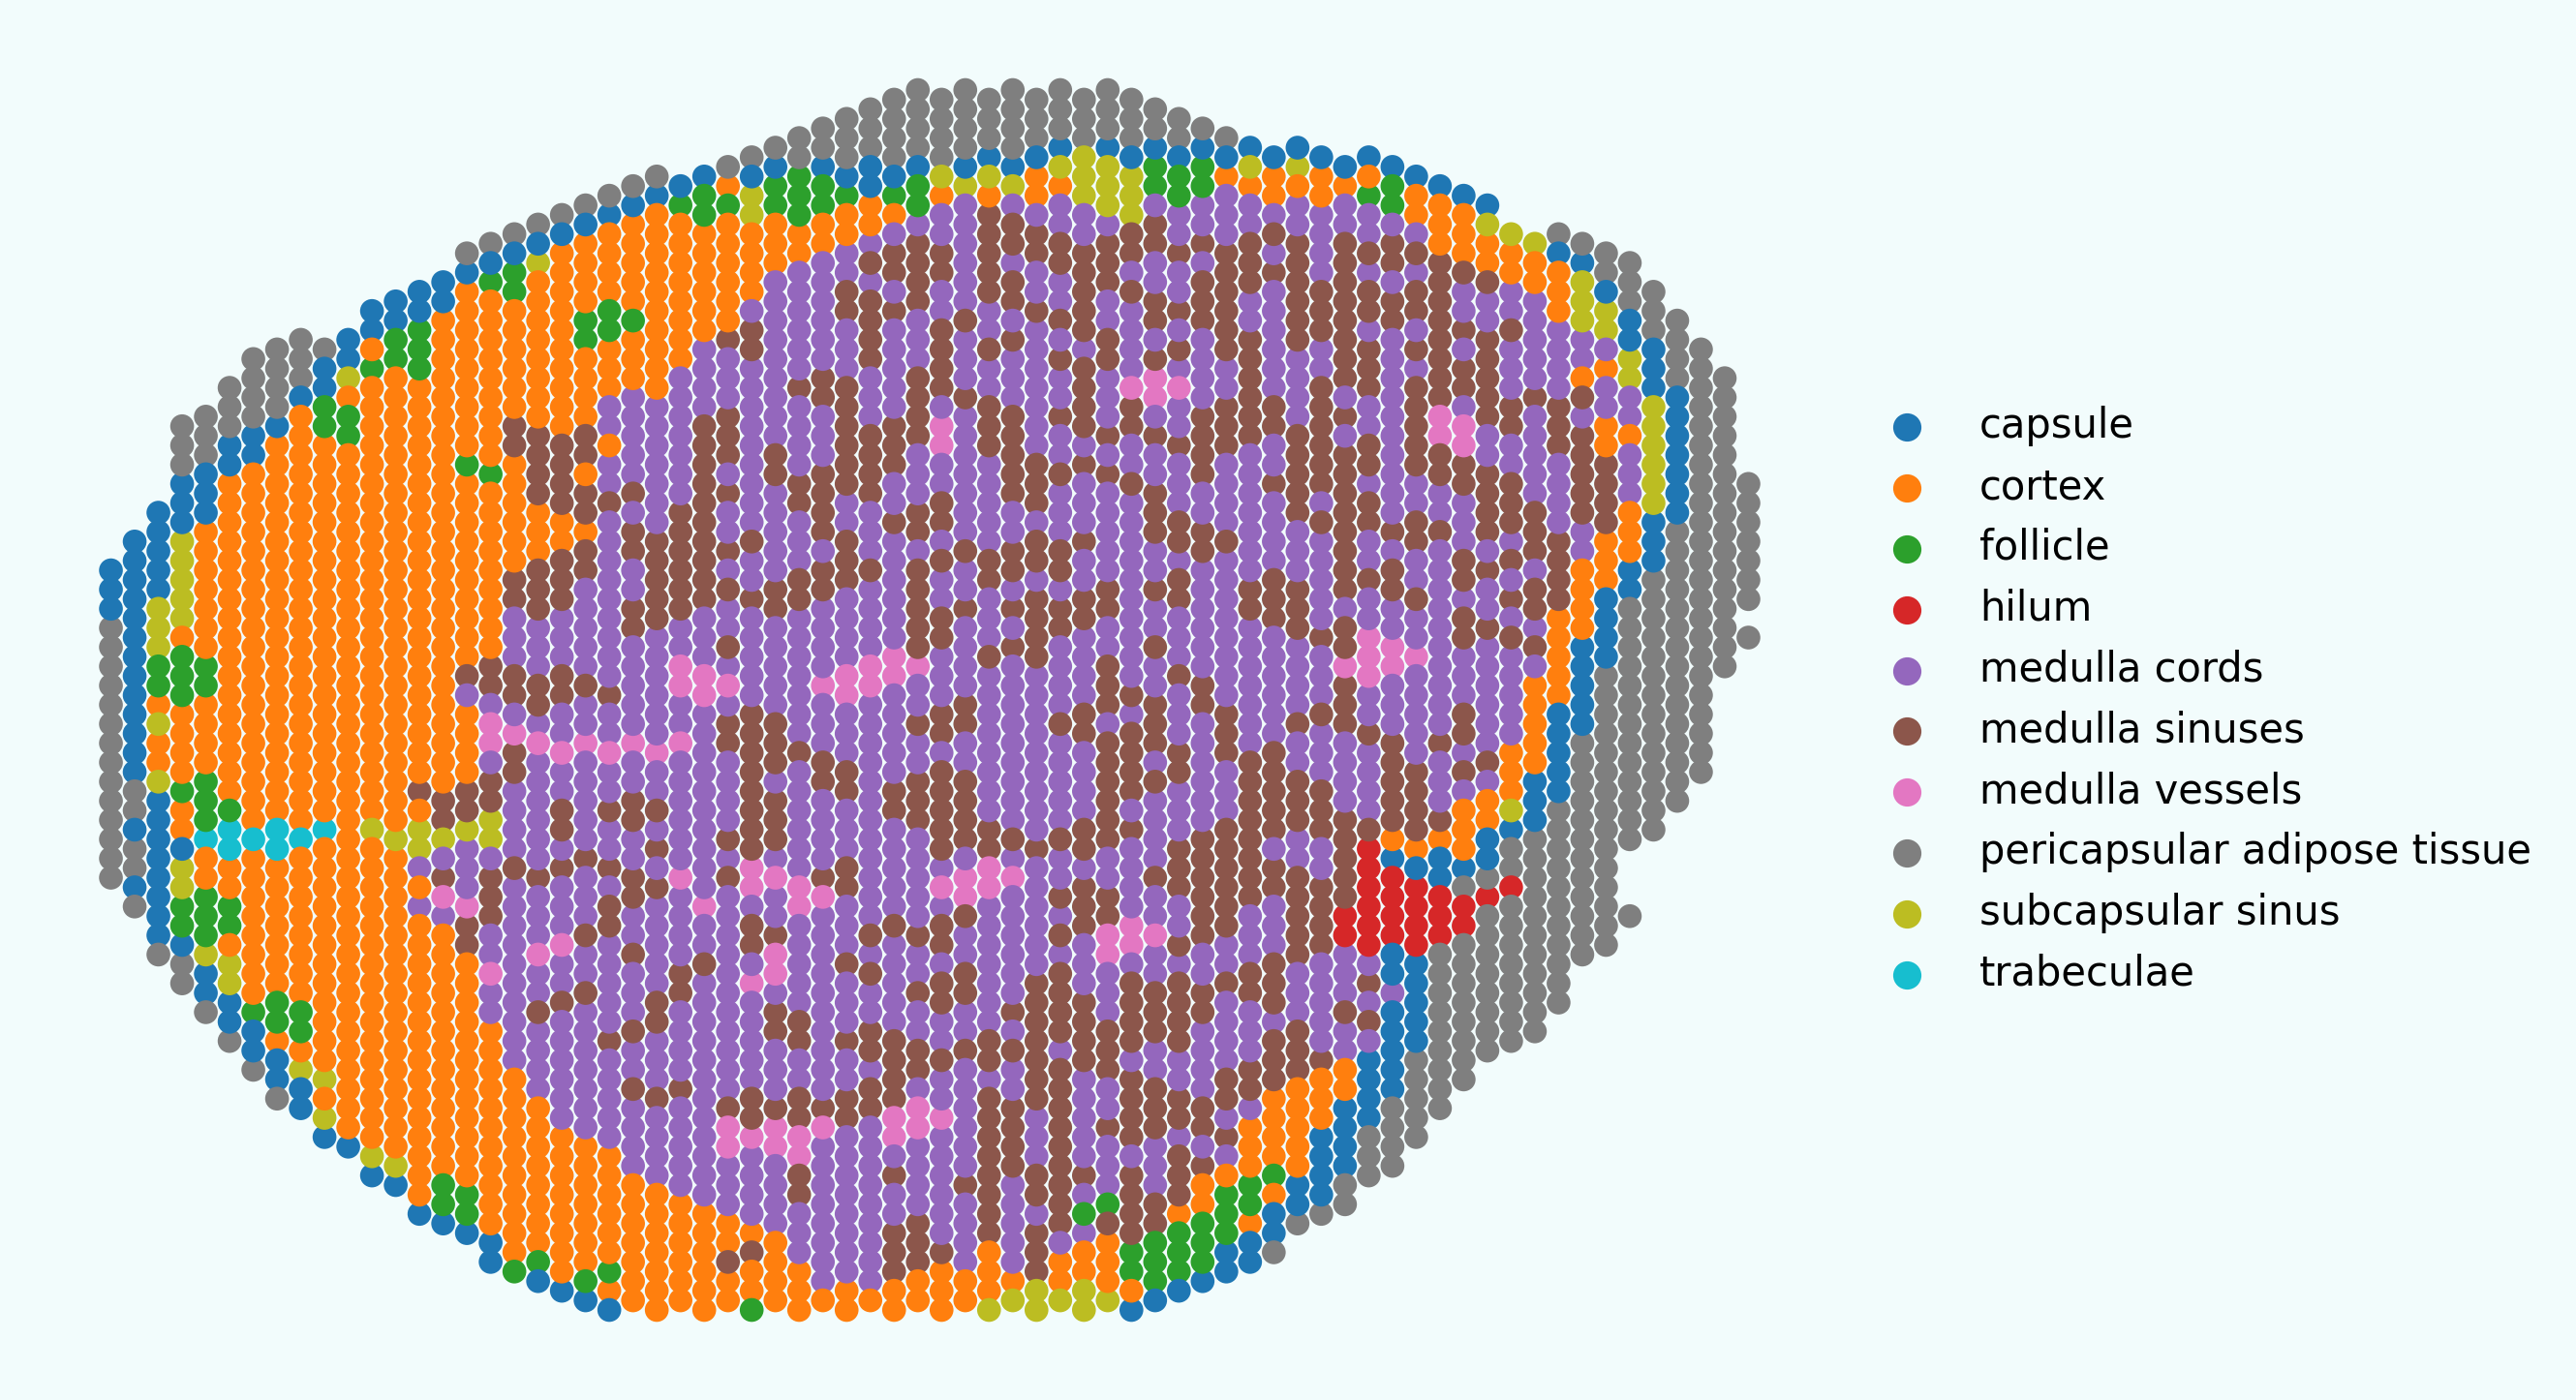

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

# 设置图的 DPI 和尺寸
dpi = 300
fig_width_inch = 8  # 图的宽度（英寸）
fig_height_inch = 6  # 图的高度（英寸）

# 创建图
fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch), dpi=dpi)
fig.patch.set_facecolor('#F2FCFC')  # 整体背景色
ax.set_facecolor('#F2FCFC')         # 坐标区域背景色

# 假设 spot 的物理直径为 1 毫米
spot_size_mm = 1
mm_per_inch = 25.4  # 每英寸的毫米数
spot_size_points = (spot_size_mm * dpi / mm_per_inch)  # 转换为点
s = spot_size_points ** 2  # 面积

# 绘图
sc.pl.embedding(adata_omics1, basis='spatial', color='final_annot', 
                title='', s=s, ax=ax, show=False)

# 去掉边框和轴标签
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

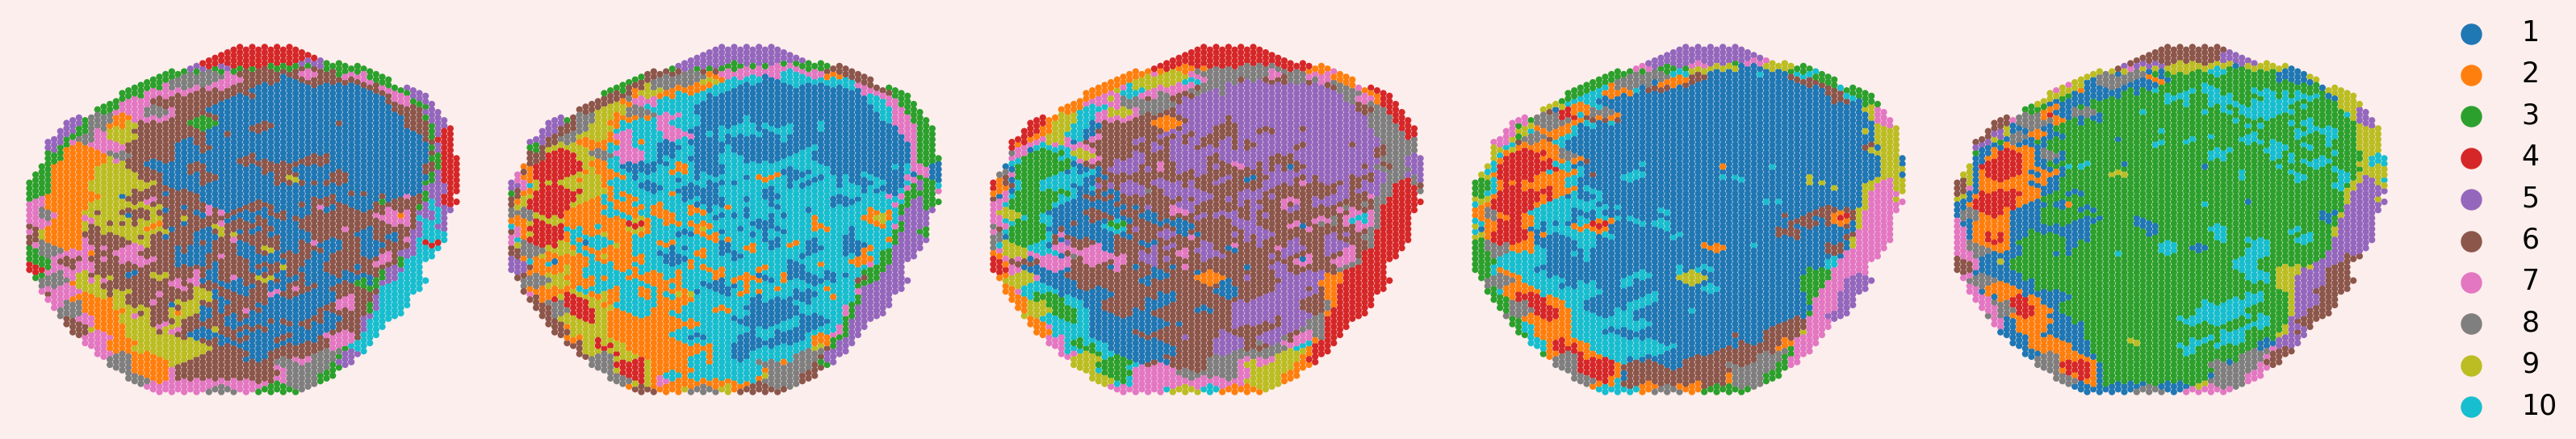

In [8]:
### 图2 空间聚类可视化结果

tool = 'mclust'
fig, ax_list = plt.subplots(1, 5, figsize=(30, 5))  # 增大图像宽度，确保子图更紧凑

# 设置整体背景色
fig.patch.set_facecolor('#FCEEEC')  # 整体背景色

# # 设置子图的坐标区域背景色
# for ax in ax_list:
#     ax.set_facecolor('#F2FCFC')  # 坐标区域背景色
    
# 对每个嵌入进行 Mclust 聚类并可视化
for i in range(5):
    emb_key = f'size{i+1}_emb'
    cluster_key = f'size{i+1}_mclust_10'  # 假设聚类的结果是 10 类
    
    # # 空间嵌入可视化
    # sc.pl.embedding(adata_vs, basis='spatial', color=cluster_key, 
    #                 ax=ax_list[i], title=method_names[i], s=50, show=False)
    
    # 无标题、空间嵌入可视化
    sc.pl.embedding(adata, basis='spatial', color=cluster_key, 
                    ax=ax_list[i], title='', frameon=False, s=s, show=False)
    
    # 删除当前子图的图例（不在子图中显示）
    ax_list[i].get_legend().set_visible(False)

# 合并图例并将其显示在最后一个子图的右侧
handles, labels = ax_list[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title='', frameon=False, 
                   markerscale=3.0,  # 调整示例圆的大小
                   fontsize=25,)

plt.tight_layout()  
plt.show()

In [ ]:
### 图3，柱状图，展示指标结果

In [9]:
###1-监督指标
import pandas as pd
from sklearn.metrics import adjusted_mutual_info_score, v_measure_score, mutual_info_score, homogeneity_score, normalized_mutual_info_score, adjusted_rand_score

# 使用 adata.obs['final_annot'] 作为真实标签
adata.obs['true_labels'] = adata.obs['final_annot']
# 去除缺失值的条形码
adata_filtered = adata[~adata.obs['true_labels'].isna()].copy()

true_labels = adata_filtered.obs['true_labels']
mclust_labels_10 = adata_filtered.obs['size1_mclust_10']

# 定义函数来计算 AMI、V-measure、Mutual Information、Homogeneity、NMI 和 ARI
def evaluate_clustering_metrics(true_labels, pred_labels):
    ami = adjusted_mutual_info_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)
    #mutual_info = mutual_info_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return ami, v_measure, homogeneity, nmi, ari
    #return ami, v_measure, mutual_info, homogeneity, nmi, ari

# 计算各个聚类结果的指标
results = {}
for i in range(1, 6):  # size1 到 size5
    mclust_labels = adata_filtered.obs[f'size{i}_mclust_10']
    
    ami, v_measure, homogeneity, nmi, ari = evaluate_clustering_metrics(true_labels, mclust_labels)
    
    # 保存结果
    results[f'Size{i}'] = {
        'AMI': ami,
        'V-measure': v_measure,
        # 'Mutual Information': mutual_info,
        'Homogeneity': homogeneity,
        'NMI': nmi,
        'ARI': ari
    }

# 转换为 DataFrame 以便于展示
results_df = pd.DataFrame(results).T  # 转置使每行代表一个聚类结果
print(results_df)


            AMI  V-measure  Homogeneity       NMI       ARI
Size1  0.368734   0.372946     0.390036  0.372946  0.240809
Size2  0.360541   0.364748     0.387224  0.364748  0.228190
Size3  0.350227   0.354392     0.386914  0.354392  0.226775
Size4  0.378590   0.383014     0.375786  0.383014  0.289081
Size5  0.402168   0.406482     0.392783  0.406482  0.296198


### 图3：柱状图修改

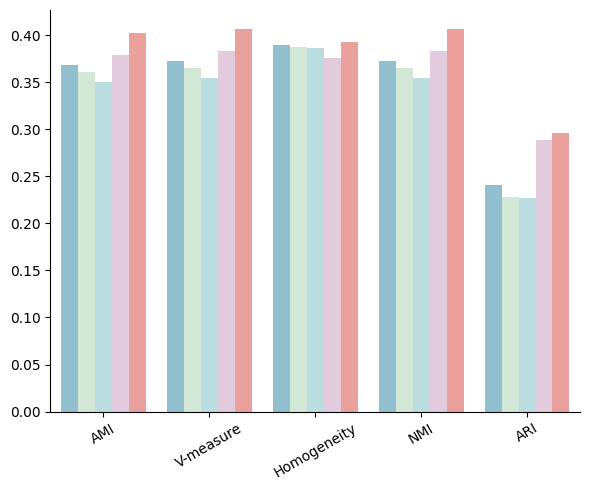

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 重新组织数据以适应绘图格式
metrics = ['AMI', 'V-measure', 'Homogeneity', 'NMI', 'ARI']
size_labels = ['Size1', 'Size2', 'Size3', 'Size4', 'Size5']

# 创建一个新的 DataFrame 长格式
data = []

for i, metric in enumerate(metrics):
    for j, size in enumerate(size_labels):
        data.append({'Metric': metric, 'Value': results_df.loc[size, metric], 'Size': size})

df = pd.DataFrame(data)

# 颜色设置
palette = {
    "Size1": "#88c4d7",
    "Size2": "#d0ead5",
    "Size3": "#b5e2e5",
    "Size4": "#e6c7df",
    "Size5": "#f79691"
}

# 绘制柱状图
plt.figure(figsize=(6, 5))
sns.barplot(data=df, x='Metric', y='Value', hue='Size', palette=palette)

# 添加标签和标题
plt.xlabel('')

plt.ylabel('')
plt.title('')
#plt.legend(title='Sizes', loc='upper right', bbox_to_anchor=(1.22, 1.01))


# 去掉边框
# 仅保留x轴和y轴的线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# 去掉图例
plt.legend().set_visible(False)  # 隐藏图例
plt.xticks(rotation=30)  # 旋转x轴刻度标签

# 显示图形
plt.tight_layout()
plt.show()
